<a href="https://colab.research.google.com/github/anmolg1997/Sentiment-Based-Product-Recommendation-System/blob/main/Sentiment_Based_Recommendation_System_Anmol_Jaiswal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [1]:
!pwd

/content


## 1. Importing Libraries

In [2]:
# dataframe and series 
import pandas as pd
import numpy as np
from scipy import stats

# sklearn imports for modeling part
import sklearn 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions

from sklearn.metrics import confusion_matrix

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

import nltk
from nltk.corpus import stopwords

from imblearn.over_sampling import SMOTE

In [3]:
pd.options.display.max_columns=100 # To see the hidden columns in dataframe

## 2. Importing Input Data

In [4]:
data_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQYEcAEM_yOk5W6dk3Z-SFmQfeM-Dcoan3l8vCVpOJdjV6Q50zJM4EI5_2ZNYQub5nY7-jouXa_M6-n/pub?output=csv"

data = pd.read_csv(data_url, parse_dates=True)
data.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive


## 3. Basic Data Understanding

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [6]:
# converting reviews to str dtype 
data.reviews_username = data.reviews_username.astype(str)

In [7]:
# Rating  - Basic stats
data.describe().T

,count,mean,std,min,25%,50%,75%,max
reviews_rating,30000.0,4.483133,0.988441,1.0,4.0,5.0,5.0,5.0


## 4. Data Cleaning

### 4.1 Missing % of each column

In [8]:
missing_df = round(100*data.isnull().sum()/len(data),2)
missing_df

id                       0.00
brand                    0.00
categories               0.00
manufacturer             0.47
name                     0.00
reviews_date             0.15
reviews_didPurchase     46.89
reviews_doRecommend      8.57
reviews_rating           0.00
reviews_text             0.00
reviews_title            0.63
reviews_userCity        93.57
reviews_userProvince    99.43
reviews_username         0.00
user_sentiment           0.00
dtype: float64

### 4.2 Dropping columns with missing values more than 25 %

In [9]:
data.drop(missing_df[missing_df > 25].index.tolist(), axis = 1, inplace = True)

In [10]:
round(100*data.isnull().sum()/len(data),4)

id                     0.0000
brand                  0.0000
categories             0.0000
manufacturer           0.4700
name                   0.0000
reviews_date           0.1533
reviews_doRecommend    8.5667
reviews_rating         0.0000
reviews_text           0.0000
reviews_title          0.6333
reviews_username       0.0000
user_sentiment         0.0033
dtype: float64

In [11]:
data.isnull().sum()

id                        0
brand                     0
categories                0
manufacturer            141
name                      0
reviews_date             46
reviews_doRecommend    2570
reviews_rating            0
reviews_text              0
reviews_title           190
reviews_username          0
user_sentiment            1
dtype: int64

#### 4.2.2 Dropping Null value rows from user_sentiment

In [12]:
data = data[data['user_sentiment'].notna()]

### 4.3 Choosing columns which are Relevant for the Analysis 

In [13]:
df= data[['brand', 'categories', 'manufacturer', 'name',
       'reviews_doRecommend', 'reviews_rating', 'reviews_text',
       'reviews_title', 'reviews_username', 'user_sentiment']]

### 4.4 Mapping categorical to 1/0

In [14]:
df['reviews_doRecommend'] = df['reviews_doRecommend'].map(dict([(False,0),(True,1)]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
df['user_sentiment'] = df['user_sentiment'].map(dict([('Negative',0),('Positive',1)]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                29999 non-null  object 
 1   categories           29999 non-null  object 
 2   manufacturer         29858 non-null  object 
 3   name                 29999 non-null  object 
 4   reviews_doRecommend  27429 non-null  float64
 5   reviews_rating       29999 non-null  int64  
 6   reviews_text         29999 non-null  object 
 7   reviews_title        29809 non-null  object 
 8   reviews_username     29999 non-null  object 
 9   user_sentiment       29999 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.5+ MB


## 5 EDA

### 5.1 Distribution of the rating

In [17]:
df['reviews_rating'].value_counts() 


5    20830
4     6020
1     1384
3     1345
2      420
Name: reviews_rating, dtype: int64

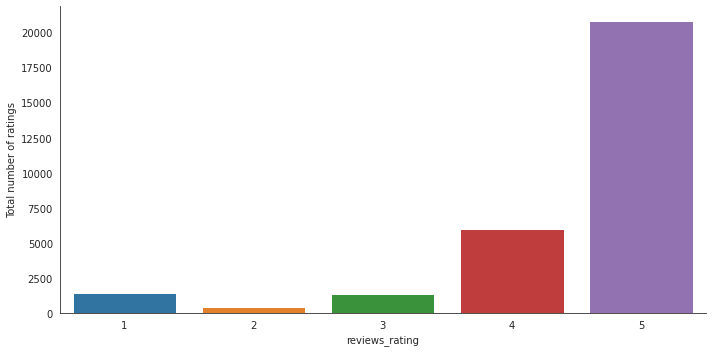

In [18]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.catplot( x='reviews_rating', data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

### 5.2 Unique Users and products

In [19]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.reviews_username)))
print("Total No of products  :", len(np.unique(df.name)))

Total data 
--------------------------------------------------

Total no of ratings : 29999
Total No of Users   : 24915
Total No of products  : 271


### 5.3 Analyzing the rating

In [20]:
#Analysis of rating given by the user 

no_of_rated_products_per_user = df.groupby(by='reviews_username')['reviews_rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

reviews_username
nan                  63
mike                 41
byamazon customer    41
chris                32
lisa                 16
Name: reviews_rating, dtype: int64

In [21]:
no_of_rated_products_per_user.describe()

count    24915.000000
mean         1.204054
std          0.864706
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         63.000000
Name: reviews_rating, dtype: float64

In [22]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

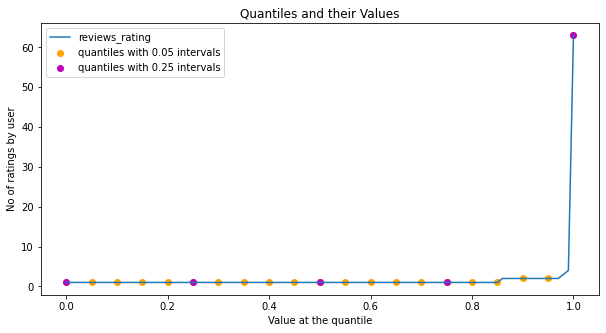

In [23]:
plt.figure(figsize=(10,5))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [24]:
print('\n No of rated product more than 15 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 15)) )


 No of rated product more than 15 per user : 8



## 6. Data Preprocessing

### 6.1 Preprocessing the Reviews_text - Lowering the case


In [25]:
df['reviews_text']=df['reviews_text'].str.lower() 
# to make all letters lower  - For computers, 'Book' is not same word with 'book'. So, I will convert every letter in the text lowercase. And, clean the punctuations from text to make them more accurate for my model.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### 6.2 Preprocessing the Reviews_text - Removing the punctuation


In [26]:
import string
string.punctuation # to see punctuation library of string function

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [27]:
def remove_punctuation(text):
    '''this function splits the words to letters, remove punctuation and 
        again getting together letters as words '''
    text_no_punc = "".join([c for c in text if c not in string.punctuation])
    return text_no_punc

In [28]:
#removing punctuation & adding review header & review text after cleaning to a new column
df['reviews_text_clean'] = df['reviews_title'].apply(lambda x: remove_punctuation(str(x))) + ' ' + df['reviews_text'].apply(lambda x: remove_punctuation(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
df['reviews_text_clean']

0        Just Awesome i love this album its very good m...
1        Good good flavor this review was collected as ...
2                                         Good good flavor
3        Disappointed i read through the reviews on her...
4        Irritation my husband bought this gel for us t...
                               ...                        
29995    Softness i got this conditioner with influenst...
29996    I love it i love it  i received this for revie...
29997    Hair is so smooth after use first of all i lov...
29998    Perfect for my oily hair i received this throu...
29999    Conditioned into healthy i received this produ...
Name: reviews_text_clean, Length: 29999, dtype: object

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                29999 non-null  object 
 1   categories           29999 non-null  object 
 2   manufacturer         29858 non-null  object 
 3   name                 29999 non-null  object 
 4   reviews_doRecommend  27429 non-null  float64
 5   reviews_rating       29999 non-null  int64  
 6   reviews_text         29999 non-null  object 
 7   reviews_title        29809 non-null  object 
 8   reviews_username     29999 non-null  object 
 9   user_sentiment       29999 non-null  int64  
 10  reviews_text_clean   29999 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 3.8+ MB


### 6.3 Creating Positive sentiment Wordcloud



In [31]:
stop_words = set(STOPWORDS) # setting stop words

In [32]:
df_pos = df.loc[df['user_sentiment']==1] # positive reviews dataframe

In [33]:
# assigning word cloud 
wordcloud = WordCloud(background_color='black', stopwords = stop_words,max_words = 500,
                    max_font_size = 100, random_state = 42, width=600, height=300)

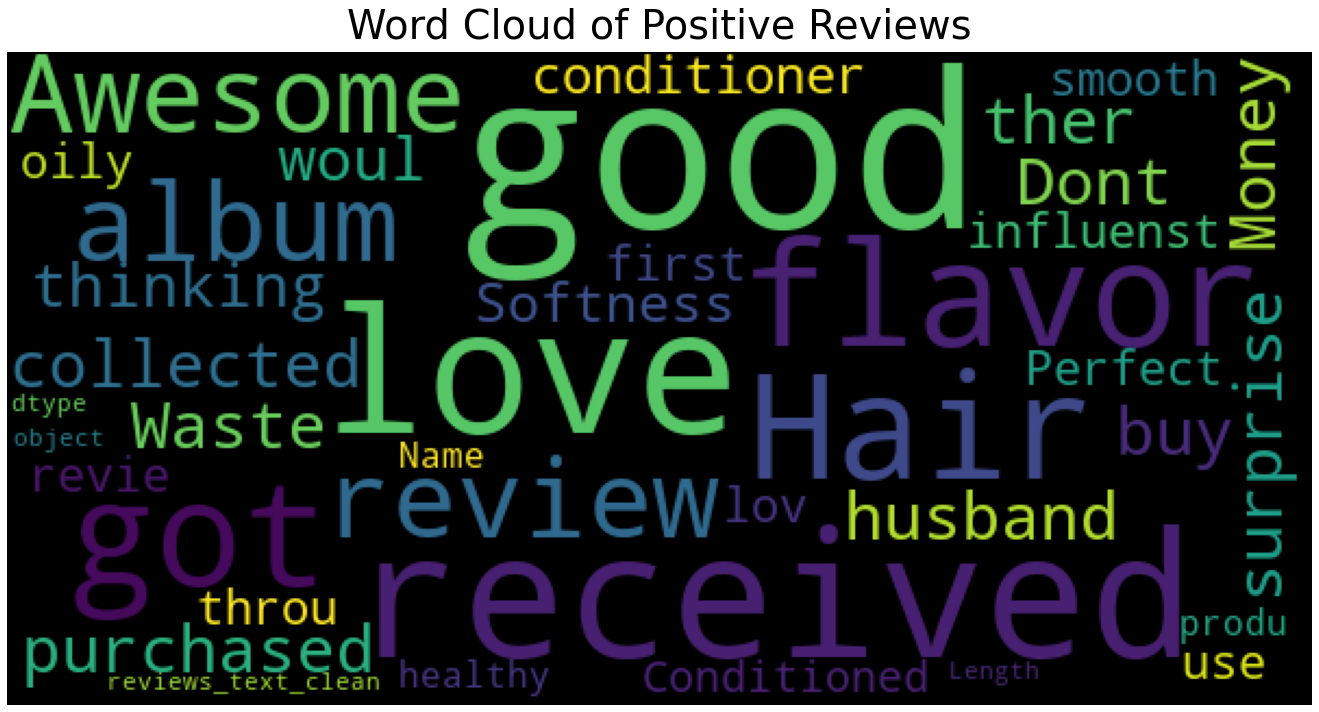

In [34]:
# to see the positive reviews wordcloud
wordcloud.generate(str(df_pos['reviews_text_clean']))
plt.figure(figsize=(20.0,10.0))
plt.imshow(wordcloud);
plt.title(f"Word Cloud of Positive Reviews", fontdict={'size': 40, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
plt.axis('off');
plt.tight_layout() 

### 6.4 Creating Negative sentiment Wordcloud


In [35]:
df_neg = df.loc[df['user_sentiment']==0] # Negative reviews dataframe

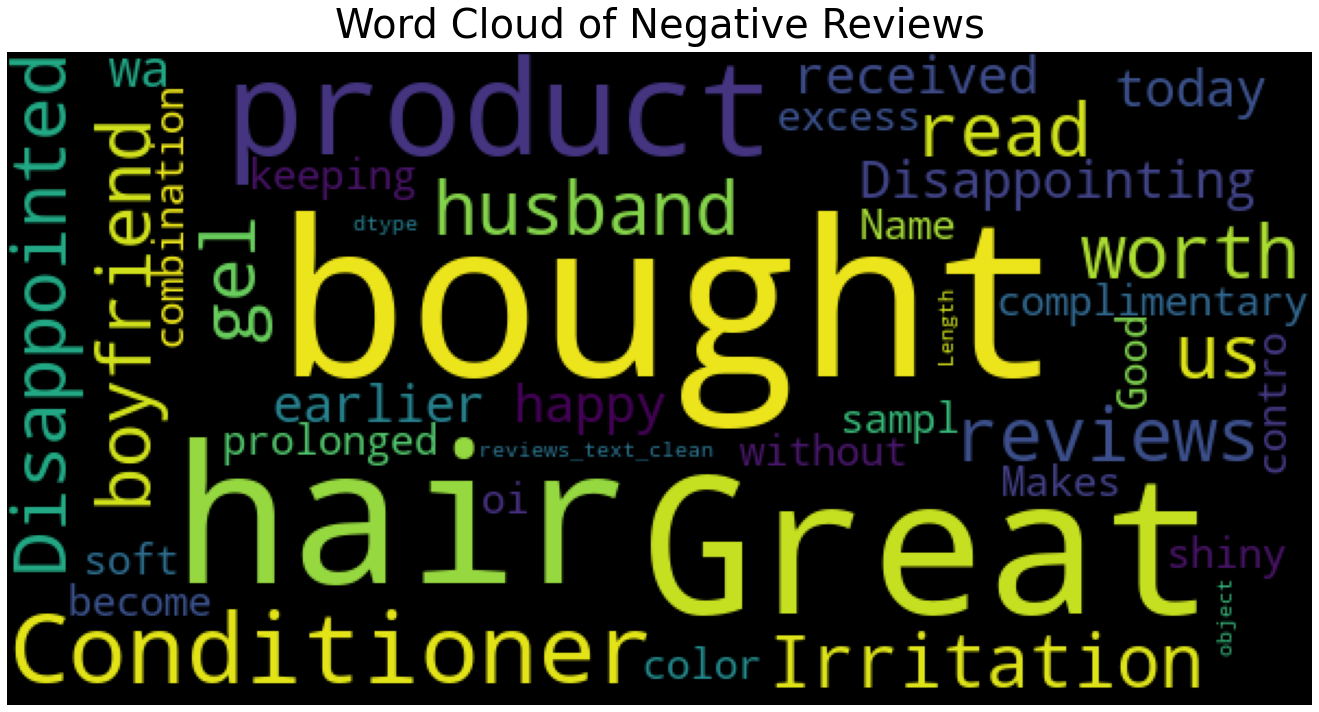

In [36]:
# to see the Negative reviews wordcloud
wordcloud.generate(str(df_neg['reviews_text_clean']))
plt.figure(figsize=(20.0,10.0))
plt.imshow(wordcloud);
plt.title(f"Word Cloud of Negative Reviews", fontdict={'size': 40, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
plt.axis('off');
plt.tight_layout() 

### 6.5 Custom functions to Look Most Common Positive and Negative Words

In [37]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [38]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [39]:
def word_count(reviews):
    '''This function tokenize and count the words in text'''
    word_num={}
    for i in reviews:
        token = nltk.word_tokenize(i)
        for t in token:
            if t not in word_num.keys():
                word_num[t] = 1
            else:
                word_num[t] += 1  
    return word_num

#### 6.5.1 Top 25 Common Words List in Positive Reviews

In [40]:
## Top 25 Common Words List in Positive Reviews
word_frequency=word_count(df_pos['reviews_text_clean']) #tokenize and count and create dictionary

In [41]:
# to create dataframe from most common words dictionary

df_pos_count = pd.DataFrame(columns=['word', 'count'])
df_pos_count['word'] = word_frequency.keys()
df_pos_count['count'] = list(word_frequency.values())
df_pos_count=df_pos_count.sort_values(by=['count'], ascending=False)
df_pos_count=df_pos_count.reset_index(drop=True)

In [42]:
stop = set(stopwords.words("english")) #setting stopwords

In [43]:
# taking only words which are not stopwords
df_pos_count['word_without_stop'] = df_pos_count['word'].apply(lambda x: ''.join([word for word in x.split() if word not in (stop)]))

In [44]:
df_pos_without_stop = df_pos_count.dropna(subset=['word_without_stop'])

In [45]:
df_top_25_pos = df_pos_count.loc[df_pos_count['word_without_stop']!=''].head(25)

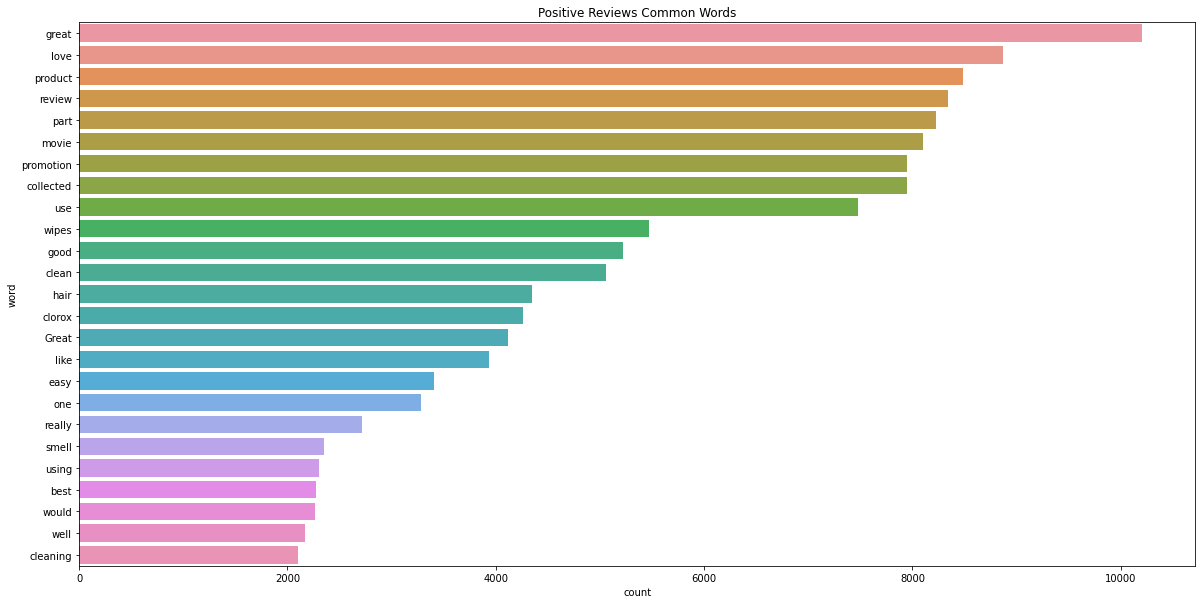

In [46]:
plt.figure(figsize=(20,10))
plt.title('Positive Reviews Common Words')
sns.barplot(y="word",x="count", data=df_top_25_pos)

#### 6.5.2 Top 25 Common Words List in Negative Reviews

In [47]:
word_frequency_neg=word_count(df_neg['reviews_text_clean'])

In [48]:
df_neg_count = pd.DataFrame(columns=['word', 'count'])
df_neg_count['word'] = word_frequency_neg.keys()
df_neg_count['count'] = list(word_frequency_neg.values())
df_neg_count=df_neg_count.sort_values(by=['count'], ascending=False)
df_neg_count=df_neg_count.reset_index(drop=True)

In [49]:
df_neg_count['word_without_stop'] = df_neg_count['word'].apply(lambda x: ''.join([word for word in x.split() if word not in (stop)]))

In [50]:
df_neg_without_stop = df_neg_count.dropna(subset=['word_without_stop'])
df_top_25_neg = df_neg_count.loc[df_neg_count['word_without_stop']!=''].head(25)

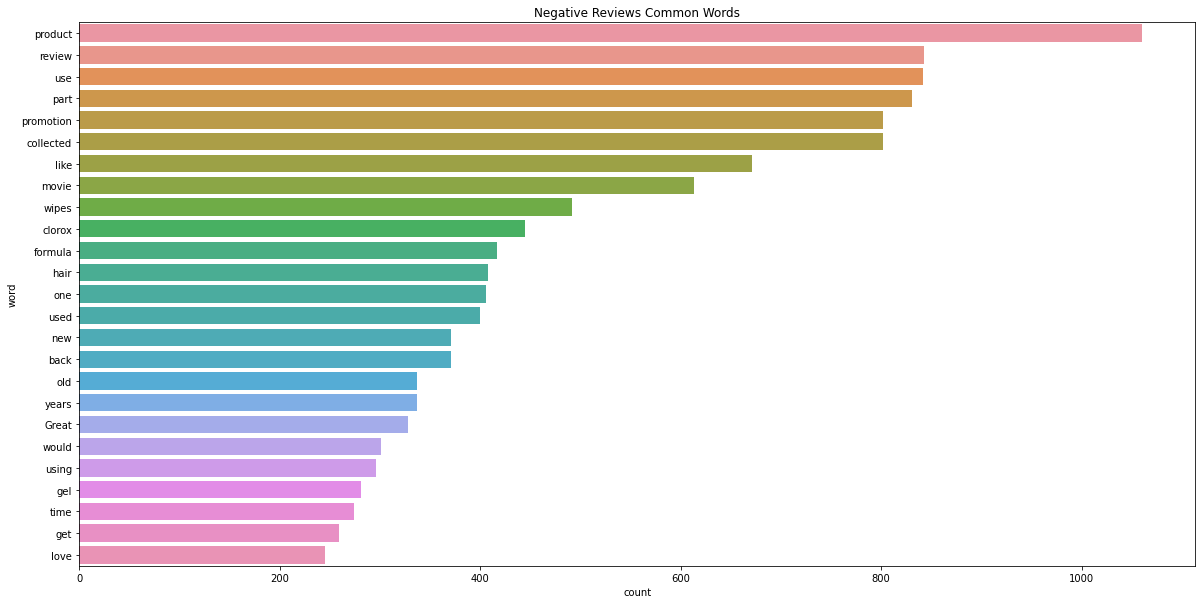

In [51]:
plt.figure(figsize=(20,10))
plt.title('Negative Reviews Common Words')
sns.barplot(y= "word",x="count", data=df_top_25_neg)

In [52]:
#using samote to handle data imbalance against user sentiment column


## 7. Sentiment Modelling

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                29999 non-null  object 
 1   categories           29999 non-null  object 
 2   manufacturer         29858 non-null  object 
 3   name                 29999 non-null  object 
 4   reviews_doRecommend  27429 non-null  float64
 5   reviews_rating       29999 non-null  int64  
 6   reviews_text         29999 non-null  object 
 7   reviews_title        29809 non-null  object 
 8   reviews_username     29999 non-null  object 
 9   user_sentiment       29999 non-null  int64  
 10  reviews_text_clean   29999 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 3.8+ MB


In [54]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

###7.1 Logistic Regression modelling

In [ ]:
def logreg_model(df) :
    '''This function splits data to train and test, then vectorized reviews 
        , handled data imbalance using SMOTE
        and calculating results from LogReg
    '''
    
    # split train-test
    X_train, X_test, y_train, y_test = train_test_split(df['reviews_text_clean'], 
                                                        df['user_sentiment'], test_size=0.2, random_state=31)
    print(X_train.shape)
    print(X_test.shape)
        
    # define vectorize and fit to data     
    word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
        analyzer='word',token_pattern=r'\w{1,}',stop_words='english',
        ngram_range=(1, 1),max_features=10000)

    word_vectorizer.fit(df['reviews_text_clean'])
    
    # train - test vectorized features
    train_word_features = word_vectorizer.transform(X_train)
    test_word_features = word_vectorizer.transform(X_test)

    # oversampling - to handle data imbalance
    sm = SMOTE(random_state = 2,sampling_strategy='auto')
    train_word_features, y_train = sm.fit_resample(train_word_features, y_train)

    print(train_word_features.shape)
    print(y_train.shape)

    # choosing and fitting classifier
    classifier = LogisticRegression(class_weight = "balanced") #, C=0.5, solver='sag')

    # Hyperparameter Tuning
    C = [(x) for x in np.logspace(start = 0 , stop = 4, num = 11)] # returns 11 numbers 
    penalty = ["l1","l2"]
    solver = ["liblinear", "saga"]
    r_grid = {'C': C, 'penalty': penalty, 'solver': solver}

    grid = {"C":np.logspace(-3,3,10), "penalty":["l1","l2"]}# l1 lasso l2 ridge
    logreg_cv = RandomizedSearchCV(estimator=classifier, param_distributions= r_grid, cv=3, n_iter = 20, scoring='f1', verbose=2, random_state=31, n_jobs=-1, return_train_score=True)
    logreg_cv.fit(train_word_features,y_train.values.ravel())

    print_results(logreg_cv)
    # calculating results 
    
    best_lr = LogisticRegression(class_weight = "balanced", **logreg_cv.best_params_)
    best_lr.fit(train_word_features,y_train)

    y_pred_train = best_lr.predict(train_word_features)
    y_pred = best_lr.predict(test_word_features)
    
    print(best_lr.score(test_word_features , y_test))

    print("Accuracy:"); print("="*len("Accuracy:"))
    print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {accuracy_score(y_test, y_pred)}")

    print("F1-Score:"); print("="*len("F1-Score:"))
    print(f"TRAIN: {f1_score(y_train, y_pred_train)}")
    print(f"TEST: {f1_score(y_test, y_pred)}")
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm)
    plt.show()

(23999,)
(6000,)
(42634, 10000)
(42634,)
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


BEST PARAMS: {'solver': 'saga', 'penalty': 'l2', 'C': 1584.893192461114}

0.921 (+/-0.007) for {'solver': 'liblinear', 'penalty': 'l1', 'C': 1584.893192461114}
0.929 (+/-0.006) for {'solver': 'liblinear', 'penalty': 'l1', 'C': 251.18864315095823}
0.905 (+/-0.01) for {'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0}
0.909 (+/-0.008) for {'solver': 'liblinear', 'penalty': 'l2', 'C': 1.0}
0.926 (+/-0.009) for {'solver': 'saga', 'penalty': 'l1', 'C': 2.51188643150958}
0.941 (+/-0.003) for {'solver': 'saga', 'penalty': 'l2', 'C': 1584.893192461114}
0.939 (+/-0.005) for {'solver': 'saga', 'penalty': 'l2', 'C': 39.810717055349734}
0.935 (+/-0.003) for {'solver': 'liblinear', 'penalty': 'l2', 'C': 630.9573444801937}
0.936 (+/-0.005) for {'solver': 'saga', 'penalty': 'l1', 'C': 6.309573444801933}
0.941 (+/-0.003) for {'solver': 'saga', 'penalty': 'l1', 'C': 10000.0}
0.939 (+/-0.004) for {'solver': 'saga', 'penalty': 'l1', 'C': 15.848931924611142}
0.936 (+/-0.006) for {'solver': 'liblinear', 'p

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


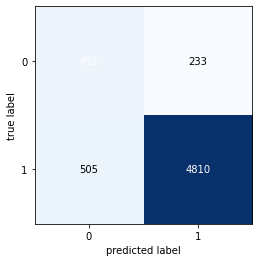

In [ ]:
logreg_model(df)

### 7.2 Random Forest Model

In [ ]:
def rf_model(df) :
    '''This function splits data to train and test, then vectorized reviews 
        , handled data imbalance using SMOTE
        and calculating results from Random Forest using RandomizedSearchCV to find best parameters for random forest classifier
    '''
    
    # split train-test
    X_train, X_test, y_train, y_test = train_test_split(df['reviews_text_clean'], 
                                                        df['user_sentiment'], test_size=0.2, random_state=31)
    print(X_train.shape)
    print(X_test.shape)
        
    # define vectorize and fit to data     
    word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
        analyzer='word',token_pattern=r'\w{1,}',stop_words='english',
        ngram_range=(1, 1),max_features=10000)

    word_vectorizer.fit(df['reviews_text_clean'])
    
    # train - test vectorized features
    train_word_features = word_vectorizer.transform(X_train)
    test_word_features = word_vectorizer.transform(X_test)

    # oversampling - to handle data imbalance
    sm = SMOTE(random_state = 2,sampling_strategy='auto')
    train_word_features, y_train = sm.fit_resample(train_word_features, y_train)

    print(train_word_features.shape)
    print(y_train.shape)

    # choosing and fitting classifier
    classifier = RandomForestClassifier(class_weight = "balanced")

    # Hyperparameter Tuning
    n_estimators = [int(x) for x in np.linspace(start = 5 , stop = 15, num = 10)] # returns 10 numbers 
    max_features = ['auto', 'log2']
    max_depth = [int(x) for x in np.linspace(5, 10, num = 2)] 
    max_depth.append(None)
    bootstrap = [True, False]
    r_grid = {'n_estimators': n_estimators,

               'max_features': max_features,

               'max_depth': max_depth,

               'bootstrap': bootstrap}

    cv= RandomizedSearchCV(estimator=classifier, param_distributions=r_grid, n_iter = 20, scoring='f1', 
                      cv = 3, verbose=2, random_state=31, n_jobs=-1, return_train_score=True)
    cv.fit(train_word_features,y_train.values.ravel())
    print_results(cv)
    
    # calculating results 
    y_pred_train = cv.predict(train_word_features)
    y_pred = cv.predict(test_word_features)

    best_random = RandomForestClassifier(class_weight = "balanced", **cv.best_params_)
    best_random.fit(train_word_features,y_train)

    print(best_random.score(test_word_features , y_test))

    print("Accuracy:"); print("="*len("Accuracy:"))
    print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {accuracy_score(y_test, y_pred)}")

    print("F1-Score:"); print("="*len("F1-Score:"))
    print(f"TRAIN: {f1_score(y_train, y_pred_train)}")
    print(f"TEST: {f1_score(y_test, y_pred)}")
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm)
    plt.show()

(23999,)
(6000,)
(42634, 10000)
(42634,)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
BEST PARAMS: {'n_estimators': 11, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}

0.951 (+/-0.023) for {'n_estimators': 15, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
0.726 (+/-0.046) for {'n_estimators': 9, 'max_features': 'auto', 'max_depth': 5, 'bootstrap': False}
0.558 (+/-0.356) for {'n_estimators': 8, 'max_features': 'log2', 'max_depth': 5, 'bootstrap': True}
0.92 (+/-0.01) for {'n_estimators': 6, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
0.544 (+/-0.316) for {'n_estimators': 6, 'max_features': 'log2', 'max_depth': 5, 'bootstrap': False}
0.928 (+/-0.014) for {'n_estimators': 10, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
0.66 (+/-0.098) for {'n_estimators': 15, 'max_features': 'log2', 'max_depth': 5, 'bootstrap': False}
0.95 (+/-0.029) for {'n_estimators': 9, 'max_features': 'auto', 'max_depth': None, 'boo

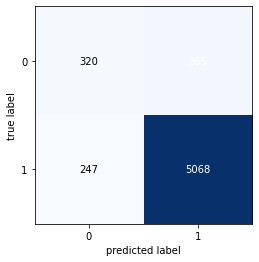

In [ ]:
rf_model(df)

### 7.3 XGBoost Model

In [ ]:
def xg_model(df) :
    '''This function splits data to train and test, then vectorized reviews 
        , handled data imbalance using SMOTE
        and calculating results from Random Forest using RandomizedSearchCV to find best parameters for random forest classifier
    '''
    
    # split train-test
    X_train, X_test, y_train, y_test = train_test_split(df['reviews_text_clean'], 
                                                        df['user_sentiment'], test_size=0.2, random_state=31)
    print(X_train.shape)
    print(X_test.shape)
        
    # define vectorize and fit to data     
    word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
        analyzer='word',token_pattern=r'\w{1,}',stop_words='english',
        ngram_range=(1, 1),max_features=10000)

    word_vectorizer.fit(df['reviews_text_clean'])
    
    # train - test vectorized features
    train_word_features = word_vectorizer.transform(X_train)
    test_word_features = word_vectorizer.transform(X_test)

    # oversampling - to handle data imbalance
    sm = SMOTE(random_state = 2,sampling_strategy='auto')
    train_word_features, y_train = sm.fit_resample(train_word_features, y_train)

    print(train_word_features.shape)
    print(y_train.shape)

    # choosing and fitting classifier
    classifier = xgb.XGBClassifier()

    # Hyperparameter Tuning
    param_dist = {
    'n_estimators':[100, 200,500,750,1000],
    'min_child_weight':[1,5,7,10], 
    'gamma':[i/10.0 for i in range(1,7)],  
    'subsample':[i/10.0 for i in range(3,9)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie', 'binary:logistic'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,9)],
}


    cv = RandomizedSearchCV(estimator = classifier, 
                            param_distributions = param_dist,
                            cv = 3,  
                            n_iter = 20, 
                            scoring = 'f1', 
                            error_score = 0, 
                            verbose = 3, 
                            n_jobs = -1, random_state=31, return_train_score=True)

    cv.fit(train_word_features,y_train.values.ravel())
    print_results(cv)
    
    # calculating results 
    y_pred_train = cv.predict(train_word_features)
    y_pred = cv.predict(test_word_features)

    best_xgb = xgb.XGBClassifier(**cv.best_params_)
    best_xgb.fit(train_word_features,y_train)

    print(best_xgb.score(test_word_features , y_test))

    print("Accuracy:"); print("="*len("Accuracy:"))
    print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {accuracy_score(y_test, y_pred)}")

    print("F1-Score:"); print("="*len("F1-Score:"))
    print(f"TRAIN: {f1_score(y_train, y_pred_train)}")
    print(f"TEST: {f1_score(y_test, y_pred)}")
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm)
    plt.show()

(23999,)
(6000,)
(42634, 10000)
(42634,)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
BEST PARAMS: {'subsample': 0.3, 'objective': 'reg:squarederror', 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 7, 'gamma': 0.2, 'eval_metric': 'rmse', 'eta': 0.6, 'colsample_bytree': 0.9, 'booster': 'gbtree'}

0.712 (+/-0.009) for {'subsample': 0.3, 'objective': 'reg:tweedie', 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'gamma': 0.6, 'eval_metric': 'rmse', 'eta': 0.5, 'colsample_bytree': 0.7, 'booster': 'gblinear'}
0.869 (+/-0.05) for {'subsample': 0.3, 'objective': 'reg:tweedie', 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 7, 'gamma': 0.5, 'eval_metric': 'rmse', 'eta': 0.5, 'colsample_bytree': 1.0, 'booster': 'gbtree'}
0.92 (+/-0.043) for {'subsample': 0.3, 'objective': 'reg:squarederror', 'n_estimators': 750, 'min_child_weight': 7, 'max_depth': 4, 'gamma': 0.4, 'eval_metric': 'rmse', 'eta': 0.4, 'colsample_bytree': 0.9, 'booster': 'gbtree'}
0.

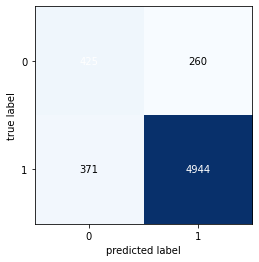

In [ ]:
xg_model(df)

### 7.4 Naive Bayes Modelling

In [ ]:
def NaiveBayes_model(df) :
    '''This function splits data to train and test, then vectorized reviews 
        , handled data imbalance using SMOTE
        and calculating results from Naive Bayes using RandomizedSearchCV to find best parameters
    '''
    
    # split train-test
    X_train, X_test, y_train, y_test = train_test_split(df['reviews_text_clean'], 
                                                        df['user_sentiment'], test_size=0.2, random_state=31)
    print(X_train.shape)
    print(X_test.shape)
        
    # define vectorize and fit to data     
    word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
        analyzer='word',token_pattern=r'\w{1,}',stop_words='english',
        ngram_range=(1, 1),max_features=10000)

    word_vectorizer.fit(df['reviews_text_clean'])
    
    # train - test vectorized features
    train_word_features = word_vectorizer.transform(X_train)
    test_word_features = word_vectorizer.transform(X_test)

    # oversampling - to handle data imbalance
    sm = SMOTE(random_state = 2,sampling_strategy='auto')
    train_word_features, y_train = sm.fit_resample(train_word_features, y_train)

    print(train_word_features.shape)
    print(y_train.shape)

    # choosing and fitting classifier
    classifier = GaussianNB()

    # Hyperparameter Tuning
    param_dist = {
    'var_smoothing': np.logspace(0,-5, num=100)
    }


    cv = RandomizedSearchCV(estimator = classifier, 
                            param_distributions = param_dist,
                            cv = 3,  
                            n_iter = 10, n_jobs = 1,
                            scoring = 'f1', error_score = 0,
                            verbose = 0, 
                            random_state=31, return_train_score=False)

    cv.fit(train_word_features.toarray(),y_train.values.ravel())
    print_results(cv)
    
    # calculating results 
    y_pred_train = cv.predict(train_word_features.toarray())
    y_pred = cv.predict(test_word_features.toarray())

    best_nb = GaussianNB(**cv.best_params_)
    best_nb.fit(train_word_features.toarray(),y_train.values.ravel())

    print(best_nb.score(test_word_features.toarray() , y_test))

    print("Accuracy:"); print("="*len("Accuracy:"))
    print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {accuracy_score(y_test, y_pred)}")

    print("F1-Score:"); print("="*len("F1-Score:"))
    print(f"TRAIN: {f1_score(y_train, y_pred_train)}")
    print(f"TEST: {f1_score(y_test, y_pred)}")
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm)
    plt.show()

(23999,)
(6000,)
(42634, 10000)
(42634,)
BEST PARAMS: {'var_smoothing': 0.001484968262254465}

0.234 (+/-0.107) for {'var_smoothing': 0.1384886371393873}
0.534 (+/-0.065) for {'var_smoothing': 0.021544346900318832}
0.658 (+/-0.014) for {'var_smoothing': 0.000145082877849594}
0.034 (+/-0.033) for {'var_smoothing': 0.7054802310718643}
0.686 (+/-0.012) for {'var_smoothing': 0.001484968262254465}
0.017 (+/-0.018) for {'var_smoothing': 1.0}
0.595 (+/-0.046) for {'var_smoothing': 0.013530477745798068}
0.088 (+/-0.064) for {'var_smoothing': 0.39442060594376555}
0.683 (+/-0.012) for {'var_smoothing': 0.0009326033468832199}
0.674 (+/-0.012) for {'var_smoothing': 0.00041320124001153384}
0.5306666666666666
Accuracy:
TRAIN: 0.7827555472158372
TEST: 0.5306666666666666
F1-Score:
TRAIN: 0.7245092207019631
TEST: 0.6608863198458573


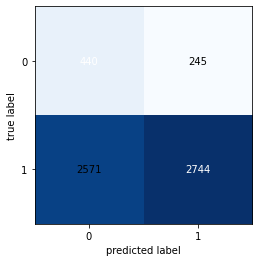

In [ ]:
NaiveBayes_model(df)

## 8. Model Selection

Considering F1-Score as the scoring measure as it will penalise model for both FP & FN, in above 3 models, performance of XGBoost is highest.

#### **Accuracy**:
TRAIN: 0.9814

TEST: 0.8948
#### **F1-Score**:
TRAIN: 0.9814

TEST: 0.9400

## 9. User Based Recommendation System

### 9.1 Splitting data into Train & Test

In [ ]:
# split train-test
train, test = train_test_split(df, test_size=0.2, random_state=31)
print(train.shape)
print(test.shape)

(23999, 11)
(6000, 11)


In [ ]:
# Pivot the train ratings' dataset into matrix format in which columns are product_names and the rows are user_names.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(0)

df_pivot.head(3)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,...,"Smead174 3-In-1 Supertab Section Folders, 1/3 Cut Top Tab, Letter, Assorted, 12/pack","Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",Solo Foods Almond Paste,Solo Foods Poppy Seed Cake and Pastry Filling,Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,Sopranos:Season 6 Part 1 (blu-Ray),Southern Enterprises Archer Fold-Away Home Bar in Walnut,Spam Single Classic,Stacy's Garden Veggie Medley Pita Chips,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek",Sunflower Swag With Metal Frame - Nearly Natural,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park 

### 9.2 Creating dummy train & dummy test dataset

These dataset will be used for prediction

- Dummy train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset.

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train."

In [ ]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [ ]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [ ]:
# Convert the dummy train dataset into matrix format.
dummy_train = pd.pivot_table( dummy_train,
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(1)

dummy_train.head(3)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,...,"Smead174 3-In-1 Supertab Section Folders, 1/3 Cut Top Tab, Letter, Assorted, 12/pack","Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",Solo Foods Almond Paste,Solo Foods Poppy Seed Cake and Pastry Filling,Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,Sopranos:Season 6 Part 1 (blu-Ray),Southern Enterprises Archer Fold-Away Home Bar in Walnut,Spam Single Classic,Stacy's Garden Veggie Medley Pita Chips,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek",Sunflower Swag With Metal Frame - Nearly Natural,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park 

### Cosine Similarity

- Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case]

### **Adjusted Cosine**

- Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different products.

### 9.3 User Similarity Matrix

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]]


In [ ]:
user_correlation.shape

(20564, 20564)

### 9.4 Using adjusted Cosine

#### 9.4.1 User - Product Matrix

In [ ]:
#Here, we are not removing the NaN values and calculating the mean only for the products rated by the user
# Create a user-product matrix.
df_pivot = pd.pivot_table( train,
    index='reviews_username',
    columns='name',
    values='reviews_rating'
)

In [ ]:
df_pivot.head(3)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,...,"Smead174 3-In-1 Supertab Section Folders, 1/3 Cut Top Tab, Letter, Assorted, 12/pack","Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",Solo Foods Almond Paste,Solo Foods Poppy Seed Cake and Pastry Filling,Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,Sopranos:Season 6 Part 1 (blu-Ray),Southern Enterprises Archer Fold-Away Home Bar in Walnut,Spam Single Classic,Stacy's Garden Veggie Medley Pita Chips,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek",Sunflower Swag With Metal Frame - Nearly Natural,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park 

#### 9.4.2 Normalising the rating of the Product for each user around 0 mean

In [ ]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

df_subtracted.head(3)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,...,"Smead174 3-In-1 Supertab Section Folders, 1/3 Cut Top Tab, Letter, Assorted, 12/pack","Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",Solo Foods Almond Paste,Solo Foods Poppy Seed Cake and Pastry Filling,Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,Sopranos:Season 6 Part 1 (blu-Ray),Southern Enterprises Archer Fold-Away Home Bar in Walnut,Spam Single Classic,Stacy's Garden Veggie Medley Pita Chips,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek",Sunflower Swag With Metal Frame - Nearly Natural,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park 

#### 9.4.3 Finding cosine similarity


In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 9.5 Prediction - User User

In [ ]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset).

In [ ]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
user_predicted_ratings.shape

(20564, 257)

Since we are interested only in the products not rated by the user, we will 
ignore the products rated by the user by making it zero. 

In [ ]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head(3)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,...,"Smead174 3-In-1 Supertab Section Folders, 1/3 Cut Top Tab, Letter, Assorted, 12/pack","Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",Solo Foods Almond Paste,Solo Foods Poppy Seed Cake and Pastry Filling,Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,Sopranos:Season 6 Part 1 (blu-Ray),Southern Enterprises Archer Fold-Away Home Bar in Walnut,Spam Single Classic,Stacy's Garden Veggie Medley Pita Chips,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek",Sunflower Swag With Metal Frame - Nearly Natural,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park 

### 9.6 Evaluation - User User 

To evaluate, we will predict for the products already rated by the user insead of predicting it for the products not rated by the user.

In [ ]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1518, 11)

In [ ]:
common.head(2)

,brand,categories,manufacturer,name,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_text_clean
20458,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,1.0,5,the product is wonderful in the shower and the...,Works great in the shower,cleansmells,1,Works great in the shower the product is wonde...
28827,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,NaN,1,"i didn't not like this product, i received it ...",Not Very Hydrating,kelly4729,1,Not Very Hydrating i didnt not like this produ...


In [ ]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [ ]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [ ]:
df_subtracted.head(1)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,...,"Smead174 3-In-1 Supertab Section Folders, 1/3 Cut Top Tab, Letter, Assorted, 12/pack","Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",Solo Foods Almond Paste,Solo Foods Poppy Seed Cake and Pastry Filling,Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,Sopranos:Season 6 Part 1 (blu-Ray),Southern Enterprises Archer Fold-Away Home Bar in Walnut,Spam Single Classic,Stacy's Garden Veggie Medley Pita Chips,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek",Sunflower Swag With Metal Frame - Nearly Natural,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park 

In [ ]:
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,20514,20515,20516,20517,20518,20519,20520,20521,20522,20523,20524,20525,20526,20527,20528,20529,20530,20531,20532,20533,20534,20535,20536,20537,20538,20539,20540,20541,20542,20543,20544,20545,20546,20547,20548,20549,20550,20551,20552,20553,20554,20555,20556,20557,20558,20559,20560,20561,20562,20563
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
common.head(1)

,brand,categories,manufacturer,name,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_text_clean
20458,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,1.0,5,the product is wonderful in the shower and the...,Works great in the shower,cleansmells,1,Works great in the shower the product is wonde...


In [ ]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()

user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [ ]:
user_correlation_df_1.shape

(1339, 20564)

In [ ]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T
print(user_correlation_df_3.shape)
user_correlation_df_3.head()

(1339, 1339)


,00sab00,1234,123charlie,4cloroxl,4djs,50cal,7inthenest,aalyah,abbey,abby,abc,abcdef,abcgator,abcssds,abigail,ace24,acellacey,acjuarez08,actionaction,adam,adelynsmom,adizzione,adma2,adriana9999,ael26,afooey,afwifey2003,aisha,aj1135,ajay,ajcrossover11,ajune,akesler19,akporter84,alena125,alex,alexa86,alexis,ali1353,alisonr,allie,ally,allyj1984,alm27,alredhouse,alvin,amanda,amanda01,amandalynn,amazing,...,trix,truckinbarbie,truth,ttdebbi,ttop,tweetyanne,twin,tyreese,ulcunique,unhappy cus to mer,unicorn351,valerie,valery,vanessavast,vicki,vickie,vicocious,victoria,viewer,vikki,vivi37,vivian,vkay,vlo910,wally,wasabi42,wendy2245,wendydarling,whythis,willy,wizard,wolf,woottos,woowoo,workingmomof1,worm,wowiezowie,wowwie,wren113,wvshopaholic,xmom,yayawomack,yellow,yesseniaw22,yeyo,ygtz,yohnie1,yshan,yummy,zburt5
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4djs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

In [ ]:
dummy_test.shape

(1339, 110)

In [ ]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_predicted_ratings.head(2)

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.","Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter","BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Batherapy Natural Mineral Bath Sport Liquid, 16 oz","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets","Burt's Bees Lip Shimmer, Raisin","Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Cetaphil Gentle Skin Cleanser, 2oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Eagle Fat Free Sweetened Condensed Milk,Equals (blu-Ray),Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Gain Original Scent Liquid Fabric Softener 129 Oz,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans",Jason Aldean - They Don't Know,"Johnson's Baby Bubble Bath and Wash, 15oz",Jolly Time Select Premium Yellow Pop Corn,"Just For Men Touch Of Gray Gray Hair Treatment, Black T-55","Kikkoman Soy Sauce, 5fl oz",Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count,Kraus FVS-1007 Single Hole Vessel Bathroom Faucet from the Ramus Collection,...,Moom Express Pre Waxed Strips For Face & Bikini,Mrs. Meyer's Lemon Verbena Surface Scrub,Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),Naturtint Nutrideep Multiplier Protective Cream,Nearly Natural 5.5' Bamboo W/decorative Planter,"Newman's Own Balsamic Vinaigrette, 16.0oz","Newman's Own Organics Licorice Twist, Black 5oz",Nexxus Exxtra Gel Style Creation Sculptor,Noosa Honey Yogurt,Ogx Anti-breakage Keratin Oil 3 Minute Miraculous Recovery,"Ogx Conditioner, Hydrating Teatree Mint",Olay Regenerist Deep Hydration Regenerating Cream,Olivella Bar Soap - 3.52 Oz,Orajel Maximum Strength Toothache Pain Relief Liquid,Pantene Pro-V Expert Collection Age Defy Conditioner,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),"Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Medium, LWS-127201","Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",Pleasant Hearth Diamond Fireplace Screen - Espresso,Power Crunch Protein Energy Bar Peanut Butter Creme Original,Ragu Roasted Garlic Parmesan Pasta Sauce,Ragu Traditional Pasta Sauce,Red (special Edition) (dvdvideo),Sabre 2 Pack Door And Window Alarm,Scooby Doo And The Loch Ness Monster (blu-Ray),"Simple Green All-Purpose Cleaner, 16oz","Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",Soothing Touch Lemon Cardamom Ve

#### 7.6.1 Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [ ]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.5618380588620018


## 10. Item Based Recommendation System

- Taking the transpose of the rating matrix to normalize the rating around the mean for different products. In the user based similarity, we had taken mean for each user instead of each product.

In [ ]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).T

df_pivot.head(3)

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,1234,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123rs,123soccermom,123too,127726,12cass12,12gage,132457,13dani,13ld,13ram,13thfaerie,1421nikki,143st,148maine,1515,15425shopper,1616,17roses,18612,1863philly,1943,1950rmm,1968bear,1970,1979edes,1992firebirdgirl,19bubba67,19granny,1awesome1,1boomer,...,zibber23,ziggy,zillafan,zillanator,zimmeyb,zina911,zink,zinnian,zipflip,zipper,zipperdoo,zippy,zitro,zittles,zkondrk,zman69,zmom,znxfyt,zod10,zodness,zoe1988,zoey,zoeyny,zokhid,zombie,zombiedad80,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoso60,zotox,zout22389,zowie,zozo0o,zpalma,zsarah,zsazsa,zt313,zubb,zulaa118,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 10.1 Normalising the product rating for each product for using the Adujsted Cosine


In [ ]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

### 10.2 Finding the cosine similarity using pairwise distances approach


In [ ]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          1.          0.         ... -0.00578588  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.         -0.00578588  0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


### 10.3 Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [ ]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### 10.4 Prediction - Item Item

In [ ]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.0166165 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01580437, 0.        , ..., 0.        , 0.0020068 ,
        0.00133049],
       ...,
       [0.        , 0.        , 0.        , ..., 0.0013682 , 0.00141937,
        0.        ],
       [0.        , 0.01716194, 0.        , ..., 0.03771556, 0.00809765,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00109456, 0.00113549,
        0.        ]])

In [ ]:
item_predicted_ratings.shape

(20564, 257)

In [ ]:
dummy_train.shape

(20564, 257)

#### 10.4.1 Filtering the rating only for the movies not rated by the user for recommendation

In [ ]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,...,"Smead174 3-In-1 Supertab Section Folders, 1/3 Cut Top Tab, Letter, Assorted, 12/pack","Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",Solo Foods Almond Paste,Solo Foods Poppy Seed Cake and Pastry Filling,Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,Sopranos:Season 6 Part 1 (blu-Ray),Southern Enterprises Archer Fold-Away Home Bar in Walnut,Spam Single Classic,Stacy's Garden Veggie Medley Pita Chips,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek",Sunflower Swag With Metal Frame - Nearly Natural,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park 

### 10.5 Evaluation - Item Item

- To evaluate, we will predict for the products already rated by the user insead of predicting it for the products not rated by the user.


In [ ]:
test.columns

Index(['brand', 'categories', 'manufacturer', 'name', 'reviews_doRecommend',
       'reviews_rating', 'reviews_text', 'reviews_title', 'reviews_username',
       'user_sentiment', 'reviews_text_clean'],
      dtype='object')

In [ ]:
common =  test[test.name.isin(train.name)]
common.shape

(5985, 11)

In [ ]:
common.head(4)

,brand,categories,manufacturer,name,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_text_clean
4332,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover,Hoover174 Platinum Collection153 Lightweight B...,1.0,5,i've only owned this product for 4 weeks so co...,Great buy,sansname,1,Great buy ive only owned this product for 4 we...
3434,Pantene,"Personal Care,Hair Care,Conditioner,Beauty,Sha...",Pantene Pro-V Hair Care,Pantene Pro-V Expert Collection Age Defy Condi...,NaN,5,this is thick stuff! i was surprised by the co...,Serious conditioning!,jennypstrong,1,Serious conditioning this is thick stuff i was...
20458,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,1.0,5,the product is wonderful in the shower and the...,Works great in the shower,cleansmells,1,Works great in the shower the product is wonde...
26478,Aveeno,"Personal Care,Sun Care,Featured Brands,Health ...",Aveeno Baby,Aveeno Baby Continuous Protection Lotion Sunsc...,NaN,1,i started to apply it on my little one and she...,What A Mess,new mommy,1,What A Mess i started to apply it on my little...


In [ ]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [ ]:
common_item_based_matrix.shape

(178, 5678)

In [ ]:
item_correlation_df = pd.DataFrame(item_correlation)

In [ ]:
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018491,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
item_correlation_df['name'] = df_subtracted.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.050188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018491,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084251,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
list_name = common.name.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T
item_correlation_df_3.head()

,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Baxter Of California Cream Pomade,Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood ceiling mounted pot rack,Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty Airspun Face Powder, Translucent Extra Coverage","Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,...,Pleasant Hearth Diamond Fireplace Screen - Espresso,Post Bound Jumbo Album - Burgundy (11x14),Power Crunch Protein Energy Bar Peanut Butter Creme Original,Queen Helene Cocoa Butter Solid,Ragu Roasted Garlic Parmesan Pasta Sauce,Ragu Traditional Pasta Sauce,Red (special Edition) (dvdvideo),Reebok Classic Leather Running Shoes - White (Men),SC Johnson One Step No Buff Wax,Sabre 2 Pack Door And Window Alarm,Scooby Doo And The Loch Ness Monster (blu-Ray),"Shea Moisture Mango & Carrot Kids Extra-Nourishing Conditioner, 8fl Oz","Simple Green All-Purpose Cleaner, 16oz",Sizzix Framelits Dies 1by Tim Holtz Bird Crazy-Silver Asst Sizes,"Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",Solo Foods Poppy Seed Cake and Pastry Filling,Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,Sopranos:Season 6 Part 1 (blu-Ray),Spam Single Classic,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Tai Pei Sweet & Sour Chicken,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Co

In [ ]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.01029717, 0.        , 0.        , ..., 0.        , 0.01234132,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02262934, 0.06538248, 0.00311394, ..., 0.06538248, 0.        ,
        0.0013682 ],
       [0.00485859, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00141937],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
common_item_predicted_ratings.shape

(178, 5678)

#### 10.5.1 Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train

In [ ]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

#### 10.5.2 The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.

In [ ]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.591571879801132


## 11. Selection - Recommendation System

Based on the evaluation of both 
1. User Based Recommendation system ( rmse = 2.56 )
2. Item Based Recommendation System ( rmse = 3.59 )

in reference to RMSE score, I am going ahead with User Based Recommendation system as it has comparatively lower RMSE value.

## 12. Recommendation by User Recommendation System :

### 12.1 Significant Users List

In [ ]:
user_df = user_final_rating.T.sum().sort_values(ascending = False)
user_list = user_df[user_df > 0].index.tolist()
print(user_list)

['marty', 'tyler', 'juice', 'joan', 'karen', 'paul', 'mr301', 'joanngr22', 'savantinsd', 'jz91345', 'asaump', 'scott', 'sheilakathleen', 'nelz214', 'vicki', 'jeanne', 'momof4', 'chips', 'zippy', 'busymom', 'adam', 'nana', 'maggie', 'amazing', 'ronnie', 'renee', 'junior', 'joey', 'bruce', 'bobby', 'reese', 'want297z', 'robb', 'macdaddy', 'val214', 'ripper', 'barra2', 'techgeek', 'george08', 'gatorbobert', 'drew', 'mark', 'josh', 'champ', 'dreamer79', 'kdawg', 'bobbi', 'bella', 'viewer', 'pcmobile', 'batman', 'yvonne', 'trish', 'loulou', 'lusient', 'mamas', 'casey', 'russ', 'eric', 'kiki', 'jimmy', 'countprice', 'ermak23', 'sidney', 'denise', 'satisfied', 'mason', 'king', 'jmoney', '1943', 'sonny', 'dharmiso', 'tomi', 'xavier', 'paula', 'wolverine', 'victor', 'zach', 'manny', 'moviegoer', 'cdavadi', 'jeff', 'thatguy', 'bryan', 'tony1', 'frank', 'kyle', 'thomas', 'peanut', 'meme', 'brian', 'thai', 'unnamed', 'moerena', 'sissy', 'mikeh', 'stacey', 'momofthree', 'robby', 'sam1', 'james', 's

### 12.2 Recommending Top 20 Products -  based on User Recommendation System

In [ ]:
# Recommending the Top 5 products to the user.
def Top20 (x):
  Top20Products = user_final_rating.loc[x].sort_values(ascending=False)[0:20].to_frame().reset_index()
  return Top20Products

## 13. Fine Tuning Recommendatations using Positive reviews %

### 13.1 Positive Reviews % at Product level

In [ ]:
review_df = df.pivot_table(index = 'name', columns = 'user_sentiment', values ='reviews_text_clean', aggfunc = len ).unstack().to_frame().reset_index().rename(columns={0: 'count'})
review_df = review_df[review_df.user_sentiment == 1]
review_df.reset_index(drop=True, inplace=True)
review_df.sort_values(by = 'count', ascending = False, ignore_index= True, inplace = True)
review_df.fillna(0, inplace=True)
review_df['Positive Sentiment %'] = 100* review_df['count']/review_df['count'].sum()

In [ ]:
review_df

,user_sentiment,name,count,Positive Sentiment %
0,1,Clorox Disinfecting Wipes Value Pack Scented 1...,7729.0,29.021478
1,1,Godzilla 3d Includes Digital Copy Ultraviolet ...,3034.0,11.392310
2,1,Clorox Disinfecting Bathroom Cleaner,1878.0,7.051667
3,1,L'or233al Paris Elvive Extraordinary Clay Reba...,1147.0,4.306849
4,1,Planes: Fire Rescue (2 Discs) (includes Digita...,1062.0,3.987684
...,...,...,...,...
266,1,Scotty Mini Double Ended Extender,0.0,0.000000
267,1,"Sloan Royal Urinal Flush Valve, 1.0 Gpf, Royal...",0.0,0.000000
268,1,Stonyfield Yobaby Peach & Pear Yogurt 4oz 6 Ct,0.0,0.000000
269,1,Sunflower Swag With Metal Frame - Nearly Natural,0.0,0.000000


### 13.2 Recommanding Top 5 Products based on Positive sentiment % of reviews

In [ ]:
def Top5(x):
  Top20Products = Top20(x)
  Top5Products = Top20Products.merge(review_df, how = 'left', on = 'name').sort_values(by = 'Positive Sentiment %', ascending = False, ignore_index = True)[:5][['name', 'Positive Sentiment %']]
  return Top5Products

## 14. Application - Recommand Top 5

In [ ]:
# Take the user ID as input
print("User List:"); print("="*len("User List:"))
print(user_list); print("-"*len(user_list))

user_input = input("\nEnter your user name: ")
print(user_input)

User List:
['marty', 'tyler', 'juice', 'joan', 'karen', 'paul', 'mr301', 'joanngr22', 'savantinsd', 'jz91345', 'asaump', 'scott', 'sheilakathleen', 'nelz214', 'vicki', 'jeanne', 'momof4', 'chips', 'zippy', 'busymom', 'adam', 'nana', 'maggie', 'amazing', 'ronnie', 'renee', 'junior', 'joey', 'bruce', 'bobby', 'reese', 'want297z', 'robb', 'macdaddy', 'val214', 'ripper', 'barra2', 'techgeek', 'george08', 'gatorbobert', 'drew', 'mark', 'josh', 'champ', 'dreamer79', 'kdawg', 'bobbi', 'bella', 'viewer', 'pcmobile', 'batman', 'yvonne', 'trish', 'loulou', 'lusient', 'mamas', 'casey', 'russ', 'eric', 'kiki', 'jimmy', 'countprice', 'ermak23', 'sidney', 'denise', 'satisfied', 'mason', 'king', 'jmoney', '1943', 'sonny', 'dharmiso', 'tomi', 'xavier', 'paula', 'wolverine', 'victor', 'zach', 'manny', 'moviegoer', 'cdavadi', 'jeff', 'thatguy', 'bryan', 'tony1', 'frank', 'kyle', 'thomas', 'peanut', 'meme', 'brian', 'thai', 'unnamed', 'moerena', 'sissy', 'mikeh', 'stacey', 'momofthree', 'robby', 'sam1', 

In [ ]:
Top5(user_input)

,name,Positive Sentiment %
0,Clorox Disinfecting Wipes Value Pack Scented 1...,29.021478
1,Planes: Fire Rescue (2 Discs) (includes Digita...,3.987684
2,"Burt's Bees Lip Shimmer, Raisin",2.883749
3,The Resident Evil Collection 5 Discs (blu-Ray),2.575849
4,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,2.406879


## 16. Experiments

In [62]:
def exp_model(df) :
    '''This function splits data to train and test, then vectorized reviews 
        , handled data imbalance using SMOTE
        and calculating results from Random Forest using RandomizedSearchCV to find best parameters for random forest classifier
    '''
    
    # split train-test
    X_train, X_test, y_train, y_test = train_test_split(df['reviews_text_clean'], 
                                                        df['user_sentiment'], test_size=0.2, random_state=31)
    print(X_train.shape)
    print(X_test.shape)
        
    # define vectorize and fit to data     
    word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
        analyzer='word',token_pattern=r'\w{1,}',stop_words='english',
        ngram_range=(1, 1),max_features=10000)

    word_vectorizer.fit(df['reviews_text_clean'])
    
    # train - test vectorized features
    train_word_features = word_vectorizer.transform(X_train)
    test_word_features = word_vectorizer.transform(X_test)

    # oversampling - to handle data imbalance
    sm = SMOTE(random_state = 2,sampling_strategy='auto')
    train_word_features, y_train = sm.fit_resample(train_word_features, y_train)

    print(train_word_features.shape)
    print(y_train.shape)
    
    best_random = RandomForestClassifier(class_weight = "balanced", n_estimators = 11, bootstrap = False )
    best_random.fit(train_word_features,y_train)

    # calculating results 
    y_pred_train = best_random.predict(train_word_features)
    y_pred = best_random.predict(test_word_features)

    
    print(best_random.score(test_word_features , y_test))

    print("Accuracy:"); print("="*len("Accuracy:"))
    print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {accuracy_score(y_test, y_pred)}")

    print("F1-Score:"); print("="*len("F1-Score:"))
    print(f"TRAIN: {f1_score(y_train, y_pred_train)}")
    print(f"TEST: {f1_score(y_test, y_pred)}")
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm)
    plt.show()

    # 
    return (test_word_features , y_test)

In [65]:
# split train-test
X_train, X_test, y_train, y_test = train_test_split(df['reviews_text_clean'], 
                                                    df['user_sentiment'], test_size=0.2, random_state=31)
print(X_train.shape)
print(X_test.shape)
    
# define vectorize and fit to data     
word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
    analyzer='word',token_pattern=r'\w{1,}',stop_words='english',
    ngram_range=(1, 1),max_features=10000)

word_vectorizer.fit(df['reviews_text_clean'])

(23999,)
(6000,)


TfidfVectorizer(max_features=10000, stop_words='english',
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\w{1,}')

In [66]:
# train - test vectorized features
train_word_features = word_vectorizer.transform(X_train)
test_word_features = word_vectorizer.transform(X_test)

In [76]:
best_random = RandomForestClassifier(class_weight = "balanced", n_estimators = 11, bootstrap = False )
best_random.fit(train_word_features,y_train)

# calculating results 
y_pred_train = best_random.predict(train_word_features)
y_pred = best_random.predict(test_word_features)

In [77]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [123]:
X_test

4332     Great buy ive only owned this product for 4 we...
3434     Serious conditioning this is thick stuff i was...
20458    Works great in the shower the product is wonde...
26478    What A Mess i started to apply it on my little...
19781    great i always use them in the bathroom kitche...
                               ...                        
1024     Windex i have always used windex and i dont pl...
20215    Clorox Fresh i have used clorox wipes since th...
24714    Godzilla rocks godzilla is my favorite movie m...
11528    Awesome product awesome product i use and reco...
271      Great product i use this product on a daily ba...
Name: reviews_text_clean, Length: 6000, dtype: object

In [121]:
test_word_features_tfidfscore = pd.DataFrame(test_word_features.toarray()).T.sum().to_frame().rename(columns={0: 'Total_TFIDF_score'})
X_test_df = X_test.to_frame().reset_index(drop = True)
y_pred_df = pd.DataFrame(y_pred).rename(columns={0: 'Predicted Sentiment'})

In [122]:
X_test_df.merge(test_word_features_tfidfscore, left_index=True, right_index=True).merge(y_pred_df, left_index=True, right_index=True)



,reviews_text_clean,Total_TFIDF_score,Predicted Sentiment
0,Great buy ive only owned this product for 4 we...,7.317278,1
1,Serious conditioning this is thick stuff i was...,5.087857,1
2,Works great in the shower the product is wonde...,2.911595,1
3,What A Mess i started to apply it on my little...,6.201184,1
4,great i always use them in the bathroom kitche...,3.232122,1
...,...,...,...
5995,Windex i have always used windex and i dont pl...,2.105240,0
5996,Clorox Fresh i have used clorox wipes since th...,4.818292,1
5997,Godzilla rocks godzilla is my favorite movie m...,2.410171,1
5998,Awesome product awesome product i use and reco...,2.771345,1


In [124]:
df.merge()

,brand,categories,manufacturer,name,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_text_clean
0,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,1,Just Awesome i love this album its very good m...
1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,NaN,5,good flavor. this review was collected as part...,Good,dorothy w,1,Good good flavor this review was collected as ...
2,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,NaN,5,good flavor.,Good,dorothy w,1,Good good flavor
3,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,0.0,1,i read through the reviews on here before look...,Disappointed,rebecca,0,Disappointed i read through the reviews on her...
4,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,0.0,1,my husband bought this gel for us. the gel cau...,Irritation,walker557,0,Irritation my husband bought this gel for us t...
...,...,...,...,...,...,...,...,...,...,...,...
29995,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,1.0,5,i got this conditioner with influenster to try...,Softness!!,laurasnchz,1,Softness i got this conditioner with influenst...
29996,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,1.0,5,"i love it , i received this for review purpose...",I love it,scarlepadilla,1,I love it i love it i received this for revie...
29997,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,1.0,5,first of all i love the smell of this product....,Hair is so smooth after use,liviasuexo,1,Hair is so smooth after use first of all i lov...
29998,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,1.0,5,i received this through influenster and will n...,Perfect for my oily hair!,ktreed95,1,Perfect for my oily hair i received this throu...
